# TODO
- Save max acc epoch
- Read sep train set, validation set

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [6]:
print( f"TensorFlow {tf.__version__}" )
import sys
print( f"Python {sys.version}\n" )


TensorFlow 2.6.0
Python 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]



In [7]:
model_input_h = input('image size :',)
train_batch_size = input('batch size :', )
if model_input_h == '':
    model_input_w = 224
    model_input_h = 224
else:
    model_input_h = int(model_input_h)
    model_input_w = model_input_h


if train_batch_size == '':
    train_batch_size = 100
else:
    train_batch_size = int(train_batch_size)
    
print(f'image size :{model_input_w}x{model_input_h}')
print('batch size :', train_batch_size)

image size :224x224
batch size : 100


# Read data

In [119]:
def read_infer_label(path, subset, size= (300,300), batch_size= 2):
    # directory = './resize/'
    # directory = './raw_data/'
    tf_raw_data = tf.keras.utils.image_dataset_from_directory(
        path,
        labels='inferred',
        # label_mode= 'categorical',#'categorical',
        label_mode= 'int',#'categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,
        image_size=size,
        shuffle=True, 
        seed=42,
        validation_split=0.2,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False
    )
    return tf_raw_data

In [116]:
# subet = 'validation'
# subset = 'training'

In [117]:
raw_train = read_infer_label('./raw_data_train/', size= (model_input_w, model_input_h), batch_size= train_batch_size)
raw_test = read_infer_label('./raw_data_test/', size= (model_input_w, model_input_h), batch_size= train_batch_size)

ValueError: If `subset` is set, `validation_split` must be set, and inversely.

In [121]:
raw_train = read_infer_label('./raw_data_train/', subset='training', size= (model_input_w, model_input_h), batch_size= train_batch_size)
raw_test = read_infer_label('./raw_data_train/', subset='validation', size= (model_input_w, model_input_h), batch_size= train_batch_size)

Found 703 files belonging to 4 classes.
Using 563 files for training.
Found 703 files belonging to 4 classes.
Using 140 files for validation.


In [124]:
import os

# Set the directory containing your dataset
data_directory = './raw_data_train'

# Initialize an empty dictionary to store the counts for each class
class_counts = {}

# Iterate over the subdirectories in the main data directory
for class_name in os.listdir(data_directory):
    class_path = os.path.join(data_directory, class_name)
    if os.path.isdir(class_path):
        class_count = len(os.listdir(class_path))
        class_counts[class_name] = class_count

# Display the counts for each class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")
    
print(raw_train.class_names)# == np.array([0.,1.,0.,0.])

Class: adventure, Count: 73
Class: cruiser, Count: 204
Class: dirt, Count: 193
Class: sport, Count: 234
['adventure', 'cruiser', 'dirt', 'sport']


# Pre processing

## Data Augmentation

In [125]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(model_input_w, model_input_h,3)),
                                        #   tf.keras.layers.RandomFlip(mode='horizontal_and_vertical', name='rand_flip'),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.2, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomCrop(model_input_w, model_input_h, seed=42, name= 'rans_crop')
                                      ],
                                     name='dataaug' )

dataaug.summary()

Model: "dataaug"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rand_flip (RandomFlip)       (None, 224, 224, 3)       0         
_________________________________________________________________
rand_trans (RandomTranslatio (None, 224, 224, 3)       0         
_________________________________________________________________
rand_rot (RandomRotation)    (None, 224, 224, 3)       0         
_________________________________________________________________
rans_crop (RandomCrop)       (None, 224, 224, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [127]:
# Define a function to apply the sequential pipeline to the data
def apply_pipeline(image, label):
    return dataaug(image), label

# Apply the sequential pipeline to the dataset
augmented_data = raw_train.map(apply_pipeline)

# # Iterate over the dataset and display the augmented images
# c = 0
# for images, labels in augmented_data:
#     for i in range(len(images)):
#         plt.imshow(images[i] / 255)  # Assuming the images are in the range [0, 255]
#         plt.title(f"Label: {labels[i]}")
#         plt.show()
#         # c+=1
#         continue
#         # if c > 10:
#         #     breako
#         # break
#     # end
#     break
    

3


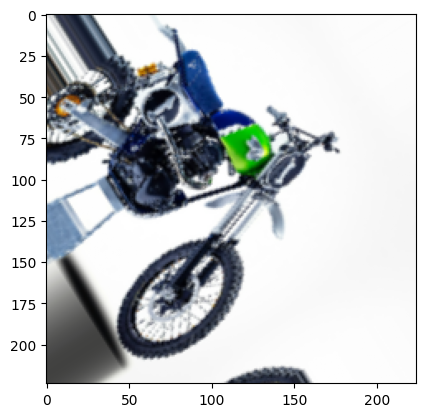

In [128]:
a = augmented_data.as_numpy_iterator()
plt.imshow(a.next()[0][0] / 255)
print(a.next()[1][0])

## Concat Raw and Augemented data

In [129]:
full_train = raw_train.concatenate(augmented_data)

## Scaling

In [130]:
scaling_layers = [
    tf.keras.Input(shape= (model_input_w, model_input_h)),
    tf.keras.layers.Rescaling(1./255)
    
]

data_scaling = tf.keras.models.Sequential(
    scaling_layers,
    name= 'data_scaling'
)

data_scaling.summary()


Model: "data_scaling"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224)          0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [131]:
scaling_bool = True

In [132]:
if scaling_bool == True:
    # Define a function to apply the sequential pipeline to the data
    def apply_scaling(image, label):
        return data_scaling(image), label

    # Apply the sequential pipeline to the dataset
    full_train_prep = full_train.map(apply_scaling)

    ## Iterate over the dataset and display the augmented images
    # c = 0
    # for images, labels in full_train_prep:
    #     for i in range(len(images)):
    #         plt.imshow(images[i])  # Assuming the images are in the range [0, 255]
    #         plt.title(f"Label: {labels[i]}")
    #         plt.show()
    #         # c+=1
    #         continue
    #         # if c > 10:
    #         #     break
    #         # break
    #     # end
    #     break
else:
    full_train_prep = full_train

        

## Data Details

In [133]:
batch = full_train_prep.as_numpy_iterator().next()
print('total data :', len(batch[0]) * len(full_train_prep))
print('N batch :', len(batch))
print('data shape :',batch[0][0].shape)
print('label example : ',batch[1][0])

total data : 1200
N batch : 2
data shape : (224, 224, 3)
label example :  2


# Transfer learning

## Get pre-trained model

### Include TOP

In [134]:
resnet_model = tf.keras.applications.ResNet50V2(
    include_top=False, # true จะใส่เขียวมา (ใส่ dense layer มาให้)
    # false จะไม่เอา dense สีเขียวมา
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='max',
    classes=1000,
    classifier_activation="softmax",
)

In [135]:
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Freeze layers

In [136]:
resnet_fz =resnet_model

for layer in resnet_model.layers:
    layer.trainable = False

In [137]:
inputs = tf.keras.Input(shape= (224,224,3))
x = resnet_fz(inputs, training= False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation= 'relu')(x)
x = tf.keras.layers.Dense(512, activation= 'relu')(x)
x = tf.keras.layers.Dense(64, activation= 'relu')(x)
outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)


### Include TOP

In [138]:
# resnet_model = tf.keras.applications.ResNet50V2(
#     include_top=True, # true จะใส่เขียวมา (ใส่ dense layer มาให้)
#     # false จะไม่เอา dense สีเขียวมา
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224,224,3),
#     pooling='avg',
#     classes=1000,
#     classifier_activation="softmax",
# )

# inputs = tf.keras.Input(shape= (224,224,3))
# x = resnet_fz(inputs, training= False)

# outputs = tf.keras.layers.Dense(4, activation= 'softmax')(x)

# transfer_model = tf.keras.Model(inputs, outputs)




In [139]:
transfer_model = tf.keras.Model(inputs, outputs)
transfer_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 260 

## Train with callback method

In [140]:
from tensorflow.keras.callbacks import Callback

class MaxAccuracyEpochScoreSaver(Callback):
    def __init__(self):
        super(MaxAccuracyEpochScoreSaver, self).__init__()
        self.max_val_accuracy = 0.0
        self.max_val_epoch = 0
        self.scores = {}

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs['val_accuracy']
        if current_val_accuracy > self.max_val_accuracy:
            self.max_val_accuracy = current_val_accuracy
            self.max_val_epoch = epoch + 1
            self.scores = {
                'Epoch': self.max_val_epoch,
                'Training Loss': logs['loss'],
                'Training Accuracy': logs['accuracy'],
                'Validation Loss': logs['val_loss'],
                'Validation Accuracy': logs['val_accuracy']
            }

    def on_train_end(self, logs=None):
        print("Max Accuracy Epoch Scores:")
        for key, value in self.scores.items():
            print(f"{key}: {value}")




In [141]:
# transfer_model.compile(optimizer= 'adam',
#                      loss= 'categorical_crossentropy',
#                      metrics= ['accuracy'])

transfer_model.compile(optimizer= 'adam',
                     loss= 'sparse_categorical_crossentropy',
                     metrics= ['accuracy'])

In [160]:
# Create an instance of the callback
max_accuracy_saver = MaxAccuracyEpochScoreSaver()

# Add the callback to the list of callbacks when fitting the model
# transfer_model.fit(full_train_prep, epochs=2, validation_data=raw_test, callbacks=[max_accuracy_saver])
transfer_model.fit(full_train, epochs=200, validation_data=raw_test, callbacks=[max_accuracy_saver])

Epoch 1/200
12/12 [==============================] - 20s 1s/step - loss: 1.8699 - accuracy: 0.6590 - val_loss: 3.9726 - val_accuracy: 0.4643
Epoch 2/200
12/12 [==============================] - 19s 1s/step - loss: 1.8364 - accuracy: 0.6554 - val_loss: 6.3179 - val_accuracy: 0.3357
Epoch 3/200
12/12 [==============================] - 19s 1s/step - loss: 2.6545 - accuracy: 0.6146 - val_loss: 3.3935 - val_accuracy: 0.5143
Epoch 4/200
12/12 [==============================] - 20s 1s/step - loss: 2.3580 - accuracy: 0.6501 - val_loss: 8.5969 - val_accuracy: 0.2643
Epoch 5/200
12/12 [==============================] - 19s 1s/step - loss: 2.8495 - accuracy: 0.5906 - val_loss: 3.2323 - val_accuracy: 0.5214
Epoch 6/200
12/12 [==============================] - 18s 1s/step - loss: 1.7842 - accuracy: 0.6732 - val_loss: 3.8553 - val_accuracy: 0.5071
Epoch 7/200
12/12 [==============================] - 17s 1s/step - loss: 2.0758 - accuracy: 0.6465 - val_loss: 4.3801 - val_accuracy: 0.3929
Epoch 8/200
1

KeyboardInterrupt: 

In [143]:
# transfer_model.fit(full_train_prep, epochs= 2)#, validation_data= raw_test)

# Evaluate

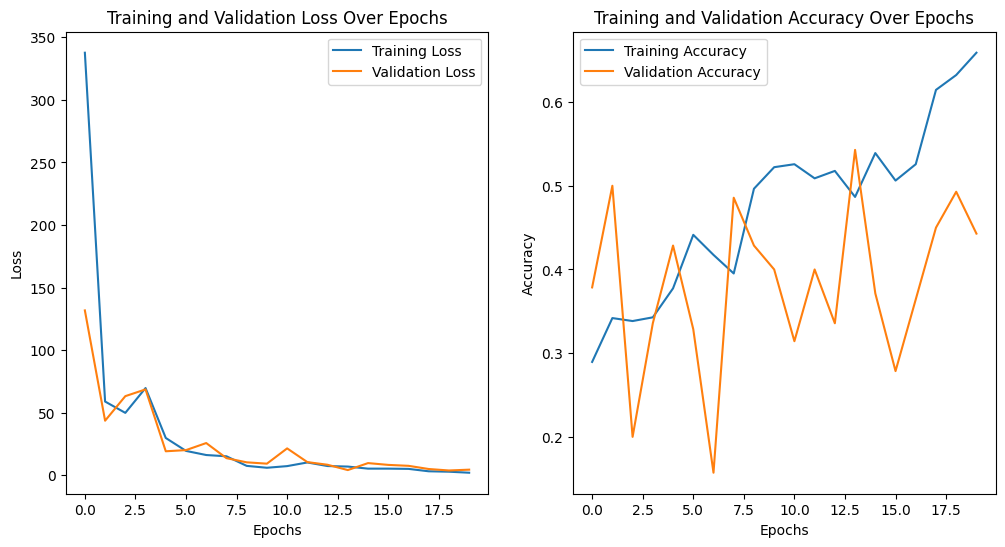

In [144]:


# Assuming 'transfer_model' is the trained model
history = transfer_model.history.history

# Retrieve the training and validation loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Create a plot for training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Create a plot for training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Display the plots
plt.show()


In [145]:
loss, acc = transfer_model.evaluate(raw_test)
print('loss :', loss)
print('acc :', acc)



2/2 [==============================] - 2s 164ms/step - loss: 4.4767 - accuracy: 0.4429
loss : 4.4767279624938965
acc : 0.44285714626312256


true : 2 pred : 0 predict : [9.8581660e-01 4.8293814e-06 1.4178331e-02 2.5715747e-07]
true : 2 pred : 2 predict : [3.1880762e-10 4.0539896e-01 5.9456730e-01 3.3763114e-05]
true : 2 pred : 2 predict : [1.6694000e-02 8.6919554e-06 9.7689819e-01 6.3991495e-03]
true : 1 pred : 0 predict : [6.8465376e-01 2.4194770e-01 7.3398530e-02 1.5754954e-12]
true : 2 pred : 3 predict : [0.0681318  0.2432589  0.01516051 0.67344886]
true : 1 pred : 2 predict : [2.9304836e-09 3.9882258e-07 9.9999964e-01 1.3259841e-09]
true : 2 pred : 2 predict : [9.8225846e-06 5.4410929e-03 9.8355550e-01 1.0993606e-02]
true : 1 pred : 1 predict : [8.0909928e-07 9.9879861e-01 1.2005264e-03 2.2623917e-12]
true : 1 pred : 1 predict : [8.5878110e-10 9.9469298e-01 5.2906596e-03 1.6402035e-05]
true : 1 pred : 0 predict : [9.9228853e-01 2.4560278e-03 5.2553439e-03 2.4942484e-10]
true : 3 pred : 1 predict : [2.5175282e-01 6.6033918e-01 8.7900579e-02 7.3892179e-06]
true : 1 pred : 2 predict : [3.4895347e-08 4.9633036e-07 9.9999952

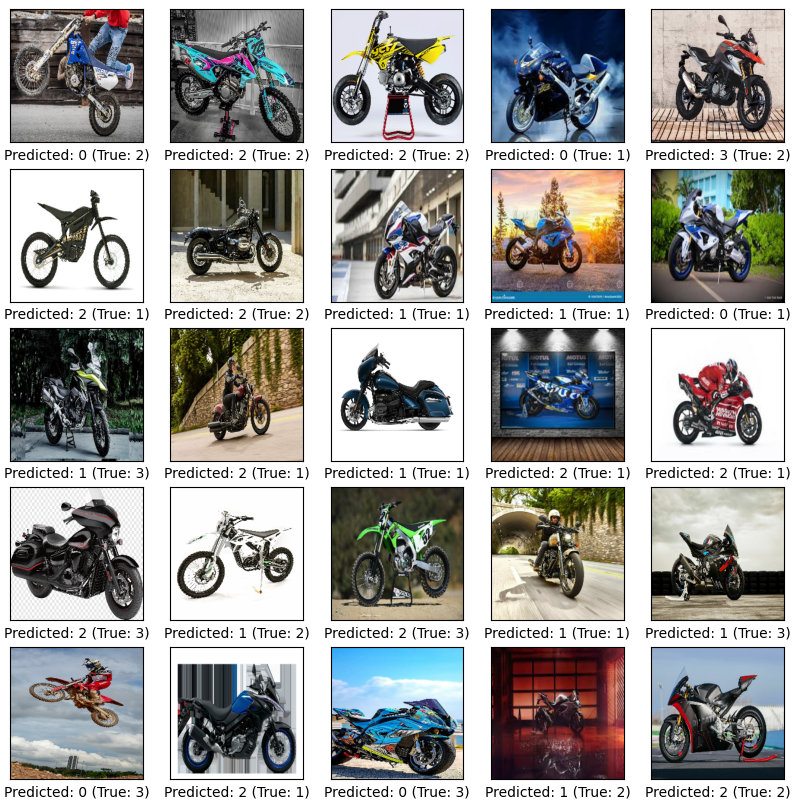

In [156]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = label#np.argmax(label)
            plt.xlabel(f"Predicted: {predicted_label} (True: {true_label})")
        else:
            true_label = label #np.argmax(label)
            plt.xlabel(f"True: {true_label}")
        print('true :', label, 'pred :', predicted_label, 'predict :', predictions[i])
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])

In [85]:
label_lst = raw_train.class_names

In [ ]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    global num_plot
    global label_lst
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = np.argmax(label_lst[label])
            plt.xlabel(f"Pred: {label_lst[predicted_label]} (True: {label_lst[true_label]})",
                       fontsize= 6)
        else:
            true_label = np.argmax(label)
            plt.xlabel(f"True: {label_lst[true_label]}",fontsize= 6)
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
num_plot = 50
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])
# plot_sample_images(test_images[:num_plot], test_labels[:num_plot], predictions[:num_plot])

pred : 1 true : adventure
pred : 2 true : cruiser
pred : 0 true : cruiser
pred : 1 true : cruiser
pred : 1 true : cruiser
pred : 1 true : adventure
pred : 0 true : adventure
pred : 3 true : cruiser
pred : 2 true : adventure
pred : 1 true : cruiser
pred : 3 true : sport
pred : 2 true : dirt
pred : 3 true : cruiser
pred : 1 true : cruiser
pred : 2 true : sport
pred : 1 true : dirt
pred : 2 true : dirt
pred : 2 true : cruiser
pred : 2 true : dirt
pred : 1 true : adventure
pred : 1 true : sport
pred : 1 true : sport
pred : 3 true : dirt
pred : 3 true : sport
pred : 2 true : dirt


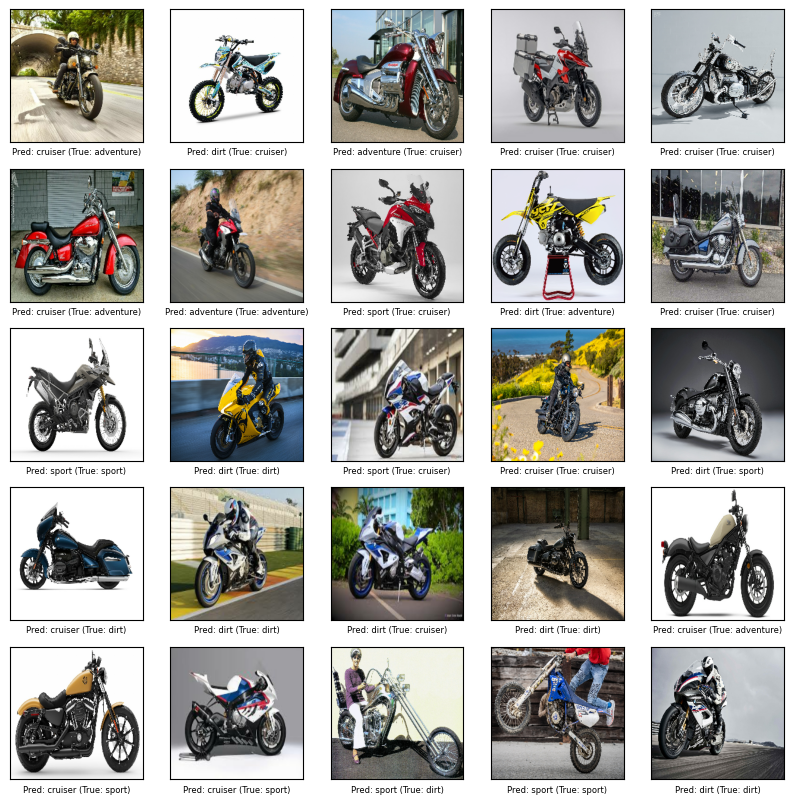

In [159]:
# Function to display a sample of images along with their predicted labels
def plot_sample_images(images, labels, predictions=None):
    global num_plot
    global label_lst
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image / 255.0)
        if predictions is not None:
            predicted_label = np.argmax(predictions[i])
            true_label = label_lst[label]
            print('pred :', predicted_label, 'true :', true_label)
            plt.xlabel(f"Pred: {label_lst[predicted_label]} (True: {true_label})",
                       fontsize= 6)
        else:
            true_label = np.argmax(label)
            plt.xlabel(f"True: {label_lst[true_label]}",fontsize= 6)
    plt.show()

# Convert the test data to numpy arrays
test_images = np.array([data[0].numpy() for data in raw_test.unbatch()])
test_labels = np.array([data[1].numpy() for data in raw_test.unbatch()])

# Generate predictions on the test images
predictions = transfer_model.predict(raw_test)

# Plot a sample of the test images with their true and predicted labels
num_plot = 50
plot_sample_images(test_images[:25], test_labels[:25], predictions[:25])
# plot_sample_images(test_images[:num_plot], test_labels[:num_plot], predictions[:num_plot])

## Grad-CAM

In [97]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [147]:
last_conv_layer_name = 'conv5_block3_out'
img_path = './raw_data_test/adventure/TRK_STYLE.jpg'
img_path = './raw_data_test/cruiser/rocket-front.jpg'
img_array = get_img_array(img_path, (224,224))
heatmap = make_gradcam_heatmap(img_array, resnet_fz, last_conv_layer_name, pred_index=None)

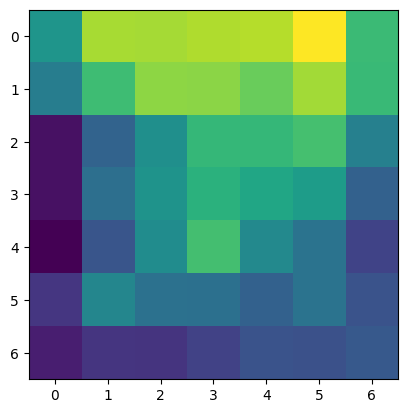

In [148]:
plt.imshow(heatmap)

C:\Users\kimte\AppData\Local\Temp\ipykernel_16180\4131525126.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


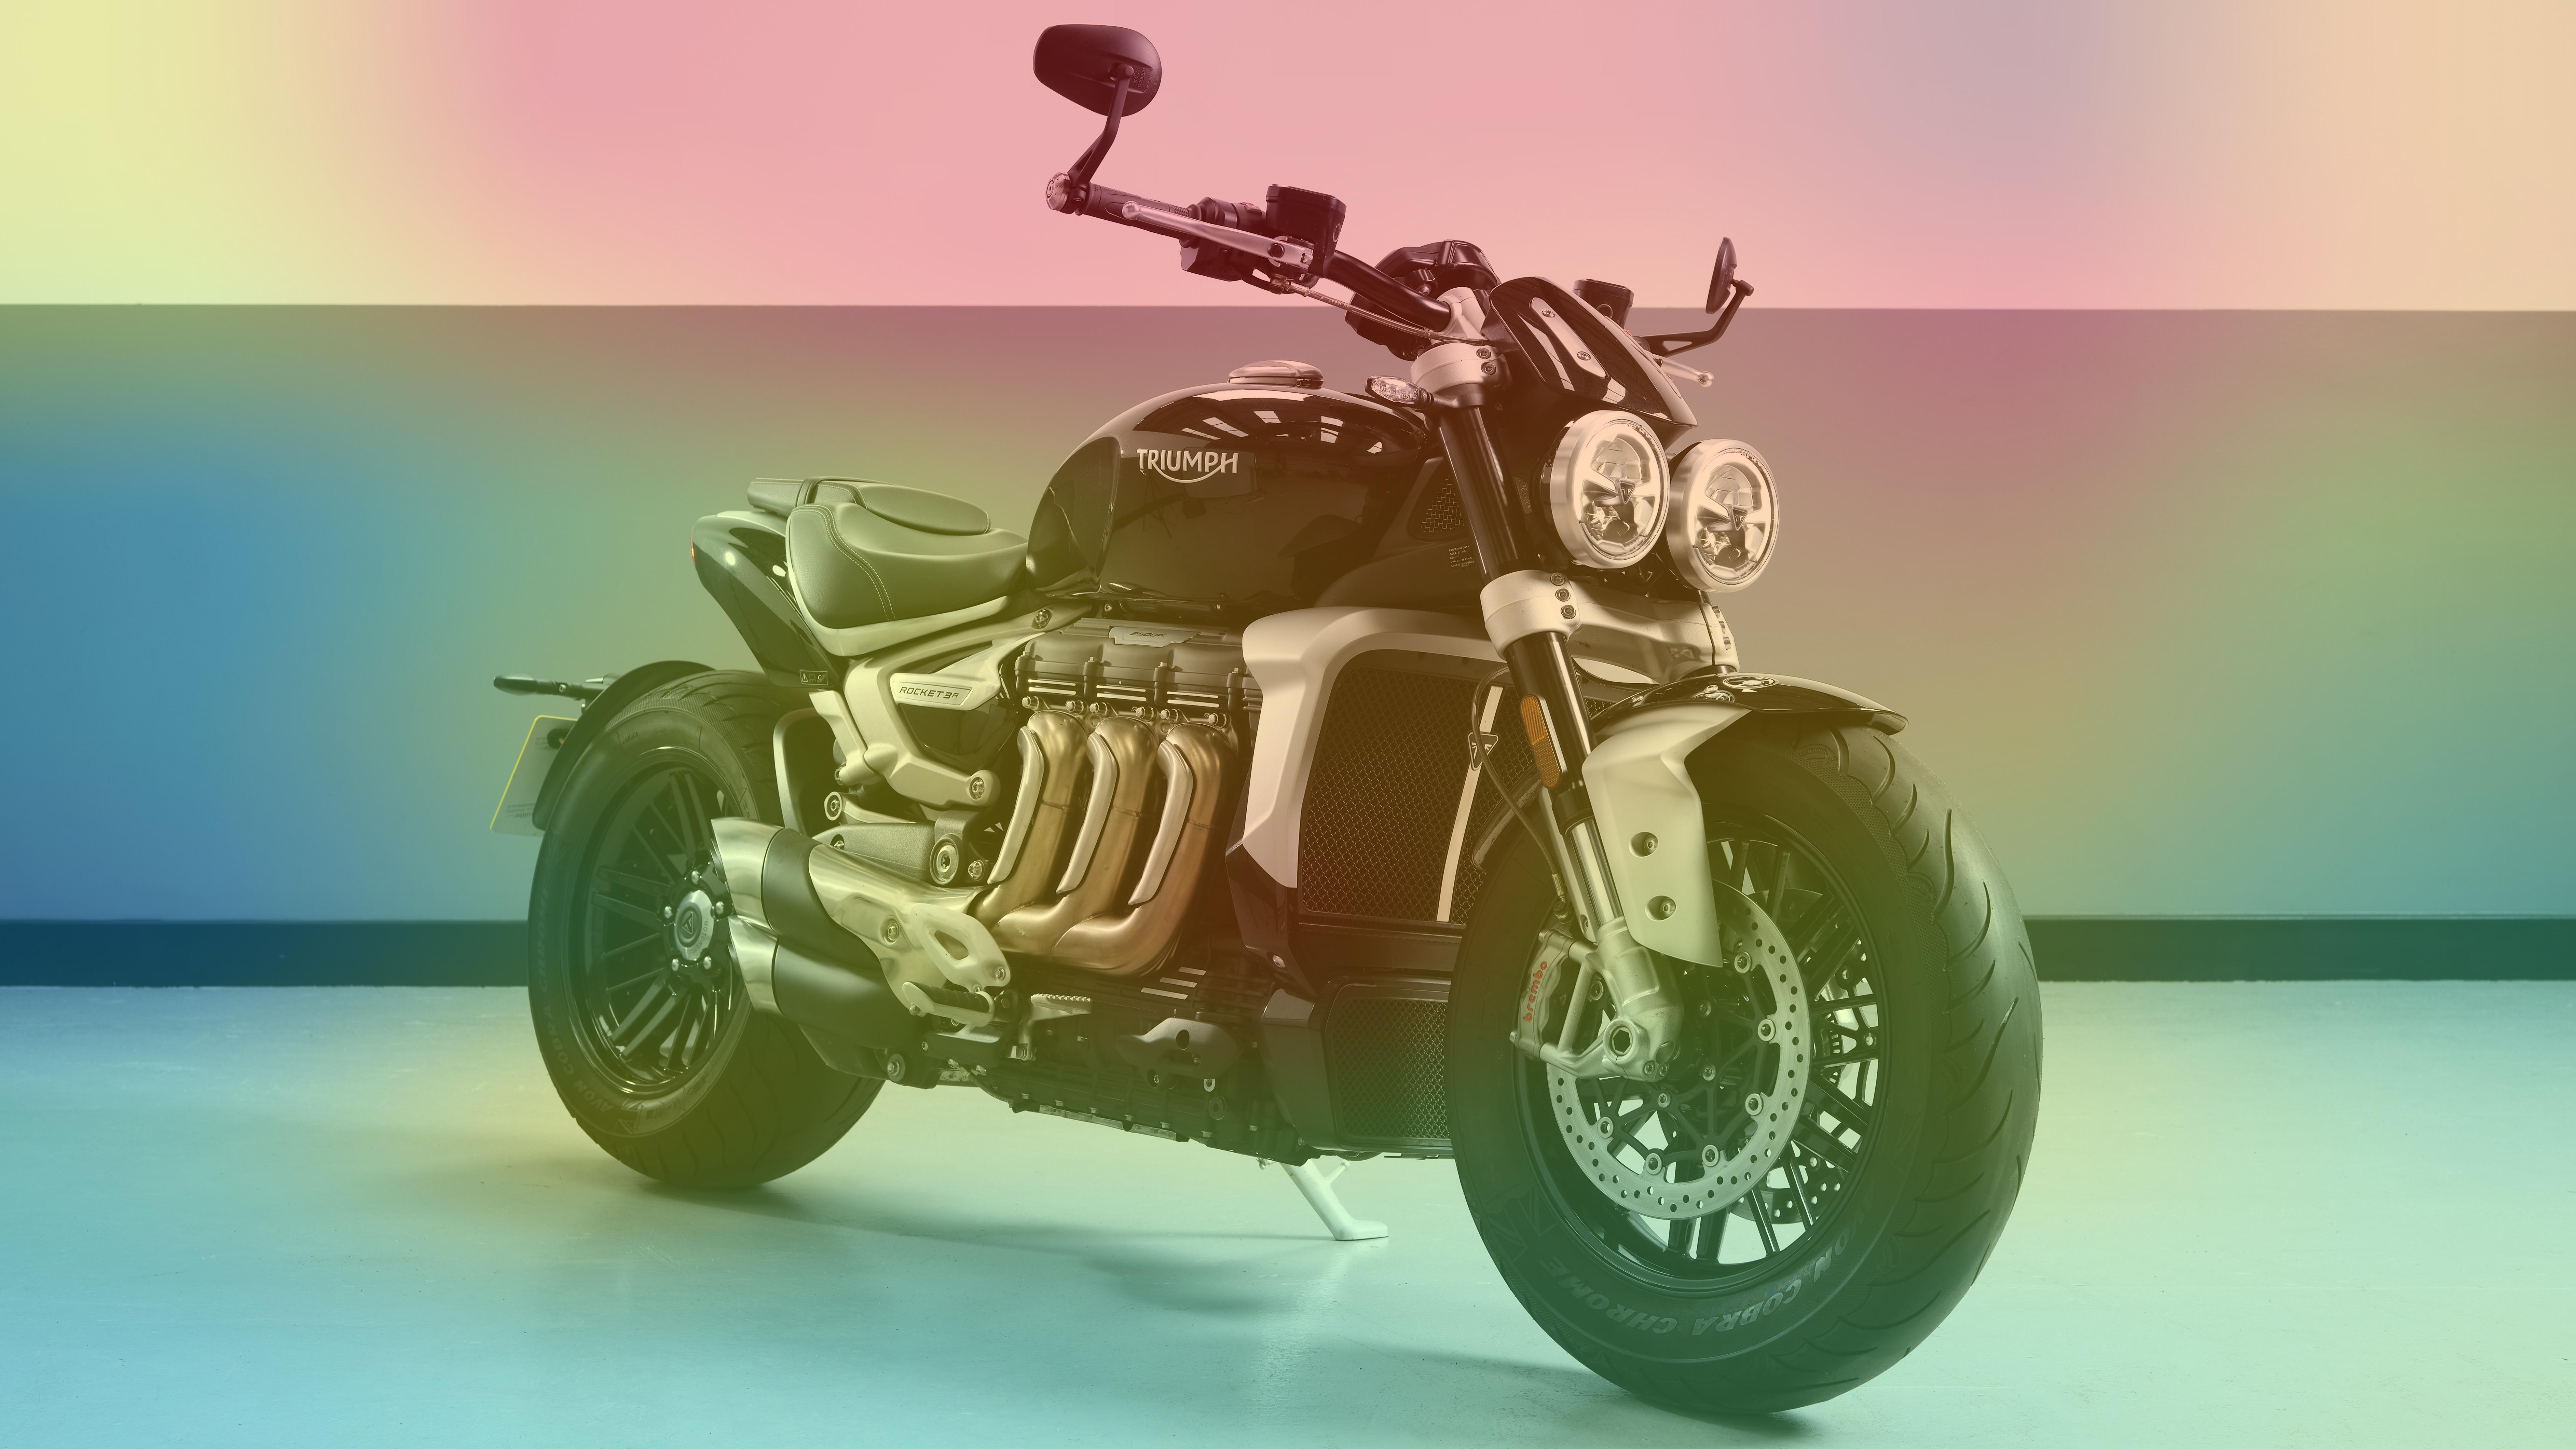

In [149]:
import matplotlib.cm as cm
from IPython.display import Image, display
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)#, cam_path= )

#### Autotune (caching??)

In [41]:
tf.data.AUTOTUNE

-1

#### test rouding 

In [44]:
print(f'{i:.6f}')

0.000677


In [46]:
for i in transfer_model.predict(raw_test)[1]:
    print(f'{i:.6f}')

0.002387
0.981088
0.016520
0.000004
